In [1]:
import pandas as pd

In [7]:
df = pd.read_csv('final_data.csv')

In [8]:
df.head()

,timestamp,open,high,low,close,volume
0,1395446400,905.34,905.34,905.34,905.34,0.0
1,1395450000,905.34,905.34,905.34,905.34,0.0
2,1395453600,905.34,905.34,905.34,905.34,0.0
3,1395457200,905.34,905.34,905.34,905.34,0.0
4,1395460800,905.34,905.34,905.34,905.34,0.0


In [9]:
df.tail()

,timestamp,open,high,low,close,volume
96538,1743260400,82554.44,82626.39,82362.10,82449.95,6069.288349
96539,1743264000,82542.72,82692.02,82167.03,82260.24,4617.631663
96540,1743267600,82259.55,82489.34,81722.86,82280.87,48203.353361
96541,1743271200,82307.70,82519.06,82135.57,82489.34,41801.147198
96542,1743274800,82345.67,82435.80,82262.24,82359.24,4177.108786


In [4]:
mbsa = pd.read_csv("mbsa.csv")

In [5]:
mbsa.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [6]:
bitcoin_data = pd.read_csv('Bitcoin_tweets.csv')


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_95292/770338702.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  bitcoin_data = pd.read_csv('Bitcoin_tweets.csv')


In [8]:
bitcoin_data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [ ]:
bitcoin_data_2 = pd.read_csv('Bitcoin_tweets_dataset_2.csv',engine='python', on_bad_lines='skip')

In [ ]:
bitcoin_data_2.head()

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import warnings

# Setup
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# ----------------------------------------
# 1. Load and Prepare OHLCV Data
# ----------------------------------------
ohlcv_df = pd.read_csv('final_data.csv')
ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='s', utc=True)
ohlcv_df.set_index('timestamp', inplace=True)
ohlcv_df.sort_index(inplace=True)

# ----------------------------------------
# 2. Load and Process Reddit Sentiment Data (Daily -> Hourly Broadcast)
# ----------------------------------------
reddit_df = pd.read_csv('mbsa.csv')
reddit_df['Date'] = pd.to_datetime(reddit_df['Date'], errors='coerce', utc=True)
reddit_df.dropna(subset=['Date'], inplace=True)

# Map sentiment labels to numerical scores
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
reddit_df['Sentiment_Score'] = reddit_df['Sentiment'].map(sentiment_mapping)

# Set to datetime index (daily only)
reddit_df.set_index('Date', inplace=True)

# Create an hourly DataFrame from OHLCV and align Reddit by date
ohlcv_df['date_only'] = ohlcv_df.index.normalize()  # strip to date
reddit_broadcast = reddit_df[['Sentiment_Score']].rename(columns={'Sentiment_Score': 'Reddit_Sentiment_Score'})

# Merge using date
ohlcv_df = ohlcv_df.merge(reddit_broadcast, left_on='date_only', right_index=True, how='left')
ohlcv_df.drop(columns=['date_only'], inplace=True)
ohlcv_df['Reddit_Sentiment_Score'].fillna(0, inplace=True)


# ----------------------------------------
# 3. Chunked Twitter Processing with Progress Bar
# ----------------------------------------
chunk_size = 100_000
tweet_file = 'Bitcoin_tweets_dataset_2.csv'

# Count total lines for tqdm progress bar (excluding header)
with open(tweet_file, 'r', encoding='utf-8', errors='ignore') as f:
    total_lines = sum(1 for line in f) - 1
total_chunks = (total_lines // chunk_size) + 1

# Process in chunks
hourly_twitter_sentiments = []

for chunk in tqdm(
    pd.read_csv(tweet_file, engine='python', on_bad_lines='skip', chunksize=chunk_size),
    total=total_chunks,
    desc="Processing Twitter Data"
):
    if 'date' not in chunk.columns or 'text' not in chunk.columns:
        continue

    chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce', utc=True)
    chunk.dropna(subset=['date'], inplace=True)
    chunk.set_index('date', inplace=True)

    chunk['Sentiment_Score'] = chunk['text'].astype(str).apply(
        lambda x: sia.polarity_scores(x)['compound']
    )

    hourly_chunk = chunk['Sentiment_Score'].resample('H').mean()
    hourly_twitter_sentiments.append(hourly_chunk)

# Combine and average all hourly chunks
twitter_sentiment = pd.concat(hourly_twitter_sentiments).groupby(level=0).mean().to_frame()
twitter_sentiment.rename(columns={'Sentiment_Score': 'Twitter_Sentiment_Score'}, inplace=True)

# ----------------------------------------
# 4. Merge Everything
# ----------------------------------------
combined_df = ohlcv_df.merge(reddit_sentiment, left_index=True, right_index=True, how='left')
combined_df = combined_df.merge(twitter_sentiment, left_index=True, right_index=True, how='left')
combined_df['Reddit_Sentiment_Score'].fillna(0, inplace=True)
combined_df['Twitter_Sentiment_Score'].fillna(0, inplace=True)

# ----------------------------------------
# 5. Output Preview
# ----------------------------------------
print(combined_df.head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/atishayjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Processing Twitter Data:  20%|███▊               | 2/10 [00:18<01:14,  9.29s/it]


In [ ]:
combined_df.head()

In [ ]:
combined_df.isna().sum()

In [ ]:
(combined_df['Twitter_Sentiment_Score']!=0.0).sum()

In [ ]:
(combined_df['Twitter_Sentiment_Score']!=0.0).sum()

In [1]:
import pandas as pd

# Load a small sample
df_tweets = pd.read_csv('Bitcoin_tweets_dataset_2.csv', nrows=5, engine='python', on_bad_lines='skip')

# Check format of 'date'
print(df_tweets['date'])

0    2023-03-01 23:59:59
1    2023-03-01 23:59:47
2    2023-03-01 23:59:42
3    2023-03-01 23:59:36
4    2023-03-01 23:59:32
Name: date, dtype: object


In [2]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'], utc=True)
print(df_tweets['date'])
print("Timezone:", df_tweets['date'].dt.tz)


0   2023-03-01 23:59:59+00:00
1   2023-03-01 23:59:47+00:00
2   2023-03-01 23:59:42+00:00
3   2023-03-01 23:59:36+00:00
4   2023-03-01 23:59:32+00:00
Name: date, dtype: datetime64[ns, UTC]
Timezone: UTC


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import warnings
import os

# Setup
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# ----------------------------------------
# 1. Load and Prepare OHLCV Data (Hourly, UTC)
# ----------------------------------------
ohlcv_df = pd.read_csv('final_data.csv')
ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='s', utc=True)
ohlcv_df.set_index('timestamp', inplace=True)
ohlcv_df.sort_index(inplace=True)

# ----------------------------------------
# 2. Load and Process Reddit Sentiment (Daily -> Hourly Broadcast)
# ----------------------------------------
reddit_df = pd.read_csv('mbsa.csv')
reddit_df['Date'] = pd.to_datetime(reddit_df['Date'], errors='coerce', utc=True)
reddit_df.dropna(subset=['Date'], inplace=True)
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
reddit_df['Sentiment_Score'] = reddit_df['Sentiment'].map(sentiment_mapping)
reddit_df.set_index('Date', inplace=True)

# Broadcast daily sentiment to hourly
ohlcv_df['date_only'] = ohlcv_df.index.normalize()
reddit_broadcast = reddit_df[['Sentiment_Score']].rename(columns={'Sentiment_Score': 'Reddit_Sentiment_Score'})
ohlcv_df = ohlcv_df.merge(reddit_broadcast, left_on='date_only', right_index=True, how='left')
ohlcv_df.drop(columns=['date_only'], inplace=True)
ohlcv_df['Reddit_Sentiment_Score'].fillna(0, inplace=True)

# ----------------------------------------
# 3. Process Twitter Sentiment in Chunks (Write to Temp File)
# ----------------------------------------
chunk_size = 50_000  # lower to reduce RAM footprint
tweet_file = 'Bitcoin_tweets_dataset_2.csv'
temp_file = 'hourly_twitter_sentiment_temp.csv'

# If temp file exists, remove it
if os.path.exists(temp_file):
    os.remove(temp_file)

# Count total lines
with open(tweet_file, 'r', encoding='utf-8', errors='ignore') as f:
    total_lines = sum(1 for line in f) - 1
total_chunks = (total_lines // chunk_size) + 1

# Process chunks and write hourly averages to temp file
for chunk in tqdm(
    pd.read_csv(tweet_file, engine='python', on_bad_lines='skip', chunksize=chunk_size),
    total=total_chunks,
    desc="Processing Twitter Sentiment"
):
    if 'date' not in chunk.columns or 'text' not in chunk.columns:
        continue

    chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce', utc=True)
    chunk.dropna(subset=['date'], inplace=True)
    chunk.set_index('date', inplace=True)

    chunk['Sentiment_Score'] = chunk['text'].astype(str).apply(
        lambda x: sia.polarity_scores(x)['compound']
    )

    hourly_sentiment = chunk['Sentiment_Score'].resample('H').mean().reset_index()
    hourly_sentiment.to_csv(temp_file, mode='a', header=not os.path.exists(temp_file), index=False)

# ----------------------------------------
# 4. Load Combined Twitter Sentiment from Temp File
# ----------------------------------------
twitter_sentiment = pd.read_csv(temp_file, parse_dates=['date'])
twitter_sentiment.set_index('date', inplace=True)
twitter_sentiment = twitter_sentiment.groupby(level=0).mean()
twitter_sentiment.rename(columns={'Sentiment_Score': 'Twitter_Sentiment_Score'}, inplace=True)

# ----------------------------------------
# 5. Merge Twitter Sentiment with OHLCV
# ----------------------------------------
combined_df = ohlcv_df.merge(twitter_sentiment, left_index=True, right_index=True, how='left')
combined_df['Twitter_Sentiment_Score'].fillna(0, inplace=True)

# ----------------------------------------
# 6. Preview or Save
# ----------------------------------------
print(combined_df.head())

# Optional: Save
# combined_df.to_csv('btc_sentiment_combined.csv')
# combined_df.to_parquet('btc_sentiment_combined.parquet')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/atishayjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Processing Twitter Sentiment:  21%|██▉           | 4/19 [00:15<00:59,  3.97s/it]


In [10]:
import pandas as pd
df = pd.read_csv('processed_OHLCV.csv')

In [11]:
df.head()

,timestamp,open,high,low,close,volume,Reddit_Sentiment_Score,Twitter_Sentiment_Score
0,2014-03-22 00:00:00+00:00,905.34,905.34,905.34,905.34,0.0,0.0,0.0
1,2014-03-22 00:59:44+00:00,905.34,905.34,905.34,905.34,0.0,0.0,0.0
2,2014-03-22 01:59:28+00:00,905.34,905.34,905.34,905.34,0.0,0.0,0.0
3,2014-03-22 02:59:12+00:00,905.34,905.34,905.34,905.34,0.0,0.0,0.0
4,2014-03-22 04:01:04+00:00,905.34,905.34,905.34,905.34,0.0,0.0,0.0


In [12]:
df.tail()

,timestamp,open,high,low,close,volume,Reddit_Sentiment_Score,Twitter_Sentiment_Score
462246866,2025-03-29 15:00:16+00:00,82554.44,82626.39,82362.10,82449.95,6069.2886,0.0,0.0
462246867,2025-03-29 16:00:00+00:00,82542.72,82692.02,82167.03,82260.24,4617.6320,0.0,0.0
462246868,2025-03-29 16:59:44+00:00,82259.55,82489.34,81722.86,82280.87,48203.3500,0.0,0.0
462246869,2025-03-29 17:59:28+00:00,82307.70,82519.06,82135.57,82489.34,41801.1500,0.0,0.0
462246870,2025-03-29 18:59:12+00:00,82345.67,82435.80,82262.24,82359.24,4177.1090,0.0,0.0


In [18]:
(df['Reddit_Sentiment_Score'] !=0.0).sum()

440799364

In [19]:
(df['Twitter_Sentiment_Score'] !=0.0).sum()

28

In [16]:
df.shape

(462246871, 8)

In [4]:
# Make sure the sentiment columns are float (just in case)
df['Reddit_Sentiment_Score'] = df['Reddit_Sentiment_Score'].astype(float)
df['Twitter_Sentiment_Score'] = df['Twitter_Sentiment_Score'].astype(float)

# Count non-zero Reddit Sentiment
reddit_nonzero = (df['Reddit_Sentiment_Score'] != 0.0).sum()

# Count non-zero Twitter Sentiment
twitter_nonzero = (df['Twitter_Sentiment_Score'] != 0.0).sum()

# Print
print(f"Non-zero Reddit sentiment rows: {reddit_nonzero}")
print(f"Non-zero Twitter sentiment rows: {twitter_nonzero}")

Non-zero Reddit sentiment rows: 440799364
Non-zero Twitter sentiment rows: 28


In [7]:
df.tail(40)

,timestamp,open,high,low,close,volume,Reddit_Sentiment_Score,Twitter_Sentiment_Score
462246831,2025-03-28 04:01:04+00:00,86854.86,86854.86,86016.63,86280.76,73205.21000,0.0,0.0
462246832,2025-03-28 05:00:48+00:00,86383.12,86383.12,85868.75,86132.06,28640.44000,0.0,0.0
462246833,2025-03-28 06:00:32+00:00,86110.65,86256.84,85732.49,85732.49,4224.38430,0.0,0.0
462246834,2025-03-28 07:00:16+00:00,85732.09,85885.09,85248.42,85339.41,10009.13600,0.0,0.0
462246835,2025-03-28 08:00:00+00:00,85269.71,85403.83,85121.07,85403.01,21589.39000,0.0,0.0
462246836,2025-03-28 08:59:44+00:00,85433.09,85433.09,85050.00,85158.49,11446.52100,0.0,0.0
462246837,2025-03-28 09:59:28+00:00,85158.49,85281.82,85032.00,85032.00,22308.97900,0.0,0.0
462246838,2025-03-28 10:59:12+00:00,85034.78,85272.13,84933.71,85272.13,8141.75440,0.0,0.0
462246839,2025-03-28 11:58:56+00:00,85220.64,87214.45,85098.43,85208.81,843060.60000,0.0,0.0
462246840,2025-03-28 13:00:48+00:00,85127.03,85508.79,85087.73,85087.73,130806.53000,0.0,0.0


In [8]:
# Make sure the columns exist and are float
df['Reddit_Sentiment_Score'] = df['Reddit_Sentiment_Score'].astype(float)
df['Twitter_Sentiment_Score'] = df['Twitter_Sentiment_Score'].astype(float)

# Find where Reddit_Sentiment_Score is NOT 0.0
reddit_nonzero_count = df[df['Reddit_Sentiment_Score'] != 0.0].shape[0]

# Find where Twitter_Sentiment_Score is NOT 0.0
twitter_nonzero_count = df[df['Twitter_Sentiment_Score'] != 0.0].shape[0]

# Print results
print(f"Rows with non-zero Reddit sentiment: {reddit_nonzero_count}")
print(f"Rows with non-zero Twitter sentiment: {twitter_nonzero_count}")

Rows with non-zero Reddit sentiment: 440799364
Rows with non-zero Twitter sentiment: 28


In [ ]:
import pandas as pd

# Load your processed dataset
df = pd.read_csv('processed_ohlcv.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Filter rows where Reddit sentiment is not 0.0
reddit_nonzero_rows = df[df['Reddit_Sentiment_Score'] != 0.0]

# Filter rows where Twitter sentiment is not 0.0
twitter_nonzero_rows = df[df['Twitter_Sentiment_Score'] != 0.0]

# Print Reddit non-zero rows
print("Reddit non-zero sentiment rows:")
print(reddit_nonzero_rows)

# Print Twitter non-zero rows
print("\nTwitter non-zero sentiment rows:")
print(twitter_nonzero_rows)

In [13]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# --- CONFIGURATION ---
SANTIMENT_API_KEY = 'qrp5ubksareynqw7_qpjfxo7bcfcmpqxg'  # <-- Replace with your Santiment API key
SANBASE_URL = 'https://api.santiment.net/graphql'
REQUESTS_PER_MINUTE = 10  # Roughly free-tier limit
RETRY_LIMIT = 5

# --- Step 1: Load OHLCV dataset ---
print("🔵 Loading OHLCV dataset...")

ohlcv_df = pd.read_csv('final_data.csv')

# Check what the timestamp looks like
sample_ts = ohlcv_df['timestamp'].iloc[0]

# Auto-detect timestamp type
if isinstance(sample_ts, str):
    # If it's a string like '2020-01-01 00:00:00'
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'])
elif isinstance(sample_ts, (int, float)):
    # If it's a large number (timestamp in ms or ns)
    if sample_ts > 1e18:
        # nanoseconds
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ns')
    elif sample_ts > 1e12:
        # milliseconds
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')
    else:
        # seconds
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='s')
else:
    raise ValueError("❌ Unknown timestamp format!")

# Now sorted
ohlcv_df.sort_values('timestamp', inplace=True)
print(f"✅ OHLCV data loaded from {ohlcv_df['timestamp'].min()} to {ohlcv_df['timestamp'].max()}\n")

# --- Step 2: Define API fetcher with retries and progress ---
def fetch_sentiment_safe(start_date, end_date, metric="sentiment_positive_total", interval="1d"):
    query = f"""
    {{
      getMetric(metric: "{metric}") {{
        timeseriesData(
          slug: "bitcoin",
          from: "{start_date}",
          to: "{end_date}",
          interval: "{interval}"
        ) {{
          datetime
          value
        }}
      }}
    }}
    """
    headers = {
        'Authorization': f'Apikey {SANTIMENT_API_KEY}',
        'Content-Type': 'application/json',
    }

    for attempt in range(RETRY_LIMIT):
        try:
            response = requests.post(SANBASE_URL, json={'query': query}, headers=headers)
            if response.status_code == 429:
                print("⚠️ Rate limited. Sleeping 60 seconds...")
                time.sleep(60)
                continue
            if response.status_code != 200:
                print(f"⚠️ Error {response.status_code}: {response.text}")
                time.sleep(5)
                continue
            data = response.json()
            timeseries = data['data']['getMetric']['timeseriesData']
            df = pd.DataFrame(timeseries)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.rename(columns={'datetime': 'timestamp', 'value': f'{metric}'}, inplace=True)
            return df
        except Exception as e:
            print(f"⚠️ Exception: {e} (Retry {attempt+1}/{RETRY_LIMIT})")
            time.sleep(5)

    raise Exception(f"❌ Failed to fetch {metric} after {RETRY_LIMIT} retries.")

# --- Step 3: Time Range ---
start_date = ohlcv_df['timestamp'].min().strftime('%Y-%m-%dT%H:%M:%SZ')
end_date = ohlcv_df['timestamp'].max().strftime('%Y-%m-%dT%H:%M:%SZ')

# --- Step 4: Fetch Sentiment ---
print("🟠 Fetching positive sentiment...")
positive_df = fetch_sentiment_safe(start_date, end_date, metric="sentiment_positive_total", interval="1d")

time.sleep(60 // REQUESTS_PER_MINUTE)  # Respect API pacing

print("🟠 Fetching negative sentiment...")
negative_df = fetch_sentiment_safe(start_date, end_date, metric="sentiment_negative_total", interval="1d")

# --- Step 5: Merge Positive and Negative ---
print("🟡 Merging sentiment data...")
sentiment_df = pd.merge(positive_df, negative_df, on='timestamp', how='outer')
sentiment_df.sort_values('timestamp', inplace=True)

# --- Step 6: Forward-Fill Sentiment Hourly ---
print("🟣 Forward-filling sentiment data to hourly...")

full_range = pd.date_range(start=ohlcv_df['timestamp'].min(), end=ohlcv_df['timestamp'].max(), freq='H')
sentiment_hourly = sentiment_df.set_index('timestamp').reindex(full_range, method='ffill')
sentiment_hourly.reset_index(inplace=True)
sentiment_hourly.rename(columns={'index': 'timestamp'}, inplace=True)

# Create Sentiment Ratio Feature
sentiment_hourly['sentiment_ratio'] = sentiment_hourly['sentiment_positive_total'] / (
    sentiment_hourly['sentiment_positive_total'] + sentiment_hourly['sentiment_negative_total'] + 1e-9
)

# --- Step 7: Merge Sentiment with OHLCV ---
print("🟢 Merging OHLCV and sentiment...")

merged_df = pd.merge(ohlcv_df, sentiment_hourly, on='timestamp', how='left')

# Fill missing sentiment (should be rare)
merged_df['sentiment_positive_total'].fillna(0, inplace=True)
merged_df['sentiment_negative_total'].fillna(0, inplace=True)
merged_df['sentiment_ratio'].fillna(0.5, inplace=True)

# --- Step 8: Save Final Merged Dataset ---
print("🟤 Saving final merged dataset...")
merged_df.to_csv('final_dataset_with_sentiment.csv', index=False)
print("✅ Done! Saved as 'final_dataset_with_sentiment.csv'.")

# --- Step 9: Show a Sample ---
print(merged_df.head())



🔵 Loading OHLCV dataset...


ValueError: ❌ Unknown timestamp format!

In [17]:
import pandas as pd
import requests
import time

# --- CONFIGURATION ---
SANTIMENT_API_KEY = 'qrp5ubksareynqw7_qpjfxo7bcfcmpqxg'  # Replace with your API key
SANBASE_URL = 'https://api.santiment.net/graphql'
REQUESTS_PER_MINUTE = 10
RETRY_LIMIT = 5

# Step 1: Load and Fix OHLCV Dataset
print("Loading OHLCV dataset...")

ohlcv_df = pd.read_csv('final_data.csv')

# Properly parse timestamps: your timestamps are in SECONDS
try:
    ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='s', errors='coerce')
    ohlcv_df['timestamp'] = ohlcv_df['timestamp'].dt.tz_localize(None)
except Exception as e:
    raise ValueError(f"Failed to parse timestamp column: {e}")

# Check if any timestamps failed parsing
if ohlcv_df['timestamp'].isnull().any():
    print(ohlcv_df[ohlcv_df['timestamp'].isnull()])
    raise ValueError("Some timestamps could not be parsed. Please fix your CSV timestamps.")

# Sort timestamps
ohlcv_df = ohlcv_df.sort_values('timestamp').reset_index(drop=True)
print(f"OHLCV data loaded successfully from {ohlcv_df['timestamp'].min()} to {ohlcv_df['timestamp'].max()}.")

# Step 2: Define function to fetch sentiment with retries
def fetch_sentiment_safe(start_date, end_date, metric="sentiment_positive_total", interval="1d"):
    query = f"""
    {{
      getMetric(metric: "{metric}") {{
        timeseriesData(
          slug: "bitcoin",
          from: "{start_date}",
          to: "{end_date}",
          interval: "{interval}"
        ) {{
          datetime
          value
        }}
      }}
    }}
    """
    headers = {
        'Authorization': f'Apikey {SANTIMENT_API_KEY}',
        'Content-Type': 'application/json',
    }

    for attempt in range(RETRY_LIMIT):
        try:
            response = requests.post(SANBASE_URL, json={'query': query}, headers=headers)
            if response.status_code == 429:
                print("Rate limited. Sleeping 60 seconds...")
                time.sleep(60)
                continue
            if response.status_code != 200:
                print(f"Error {response.status_code}: {response.text}")
                time.sleep(5)
                continue
            data = response.json()
            timeseries = data['data']['getMetric']['timeseriesData']
            df = pd.DataFrame(timeseries)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.rename(columns={'datetime': 'timestamp', 'value': f'{metric}'}, inplace=True)
            df['timestamp'] = df['timestamp'].dt.tz_localize(None)
            return df
        except Exception as e:
            print(f"Exception occurred: {e} (Retry {attempt+1}/{RETRY_LIMIT})")
            time.sleep(5)

    raise Exception(f"Failed to fetch {metric} after {RETRY_LIMIT} retries.")

# Step 3: Prepare timeframe
start_date = ohlcv_df['timestamp'].min().strftime('%Y-%m-%dT%H:%M:%SZ')
end_date = ohlcv_df['timestamp'].max().strftime('%Y-%m-%dT%H:%M:%SZ')

# Step 4: Fetch Sentiment Metrics
print("Fetching positive sentiment...")
positive_df = fetch_sentiment_safe(start_date, end_date, metric="sentiment_positive_total", interval="1d")

time.sleep(10)

print("Fetching negative sentiment...")
negative_df = fetch_sentiment_safe(start_date, end_date, metric="sentiment_negative_total", interval="1d")

# Step 5: Merge Sentiment Metrics
print("Merging sentiment data...")

sentiment_df = pd.merge(positive_df, negative_df, on='timestamp', how='outer')
sentiment_df = sentiment_df.sort_values('timestamp')

# Step 6: Forward Fill Sentiment Hourly
print("Forward-filling sentiment data to hourly...")

full_range = pd.date_range(start=ohlcv_df['timestamp'].min(), end=ohlcv_df['timestamp'].max(), freq='H')
sentiment_hourly = sentiment_df.set_index('timestamp').reindex(full_range, method='ffill')
sentiment_hourly.reset_index(inplace=True)
sentiment_hourly.rename(columns={'index': 'timestamp'}, inplace=True)
sentiment_hourly['timestamp'] = sentiment_hourly['timestamp'].dt.tz_localize(None)

# Create Sentiment Ratio feature
sentiment_hourly['sentiment_ratio'] = sentiment_hourly['sentiment_positive_total'] / (
    sentiment_hourly['sentiment_positive_total'] + sentiment_hourly['sentiment_negative_total'] + 1e-9
)

# Step 7: Merge OHLCV and Sentiment
print("Merging OHLCV and sentiment datasets...")

merged_df = pd.merge(ohlcv_df, sentiment_hourly, on='timestamp', how='left')

# Fill missing sentiment values if any
merged_df['sentiment_positive_total'].fillna(0, inplace=True)
merged_df['sentiment_negative_total'].fillna(0, inplace=True)
merged_df['sentiment_ratio'].fillna(0.5, inplace=True)

# Step 8: Save the final merged dataset
print("Saving final merged dataset...")
merged_df.to_csv('final_dataset_with_sentiment.csv', index=False)
print("Final dataset saved successfully as 'final_dataset_with_sentiment.csv'.")

# Step 9: Preview result
print(merged_df.head())

Loading OHLCV dataset...
OHLCV data loaded successfully from 2014-03-22 00:00:00 to 2025-03-29 19:00:00.
Fetching positive sentiment...
Fetching negative sentiment...
Merging sentiment data...
Forward-filling sentiment data to hourly...
Merging OHLCV and sentiment datasets...
Saving final merged dataset...
Final dataset saved successfully as 'final_dataset_with_sentiment.csv'.
            timestamp    open    high     low   close  volume  \
0 2014-03-22 00:00:00  905.34  905.34  905.34  905.34     0.0   
1 2014-03-22 01:00:00  905.34  905.34  905.34  905.34     0.0   
2 2014-03-22 02:00:00  905.34  905.34  905.34  905.34     0.0   
3 2014-03-22 03:00:00  905.34  905.34  905.34  905.34     0.0   
4 2014-03-22 04:00:00  905.34  905.34  905.34  905.34     0.0   

   sentiment_positive_total  sentiment_negative_total  sentiment_ratio  
0                       0.0                       0.0              0.5  
1                       0.0                       0.0              0.5  
2         

In [18]:
df2 = pd.read_csv('final_dataset_with_sentiment.csv')

In [20]:
df2.tail()

,timestamp,open,high,low,close,volume,sentiment_positive_total,sentiment_negative_total,sentiment_ratio
96538,2025-03-29 15:00:00,82554.44,82626.39,82362.10,82449.95,6069.288349,3.877393,1.642933,0.702385
96539,2025-03-29 16:00:00,82542.72,82692.02,82167.03,82260.24,4617.631663,3.877393,1.642933,0.702385
96540,2025-03-29 17:00:00,82259.55,82489.34,81722.86,82280.87,48203.353361,3.877393,1.642933,0.702385
96541,2025-03-29 18:00:00,82307.70,82519.06,82135.57,82489.34,41801.147198,3.877393,1.642933,0.702385
96542,2025-03-29 19:00:00,82345.67,82435.80,82262.24,82359.24,4177.108786,3.877393,1.642933,0.702385


In [21]:
# Check timestamp differences
diffs = merged_df['timestamp'].diff().value_counts()

print(diffs)


timestamp
0 days 01:00:00    96527
0 days 02:00:00        7
1 days 05:00:00        1
0 days 03:00:00        1
0 days 10:00:00        1
0 days 11:00:00        1
0 days 06:00:00        1
0 days 04:00:00        1
0 days 08:00:00        1
0 days 07:00:00        1
Name: count, dtype: int64


In [22]:
import pandas as pd

# Assuming you already have merged_df from previous steps

print("Checking and fixing missing hourly timestamps...")

# Step 1: Create full hourly timestamp range
full_range = pd.date_range(start=merged_df['timestamp'].min(), end=merged_df['timestamp'].max(), freq='H')

# Step 2: Reindex merged_df to the full range
merged_df = merged_df.set_index('timestamp').reindex(full_range).reset_index()
merged_df = merged_df.rename(columns={'index': 'timestamp'})

# Step 3: Interpolate missing OHLCV values
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume']

merged_df[ohlcv_columns] = merged_df[ohlcv_columns].interpolate(method='linear', limit_direction='both')

# Step 4: Forward-fill missing sentiment values
sentiment_columns = ['sentiment_positive_total', 'sentiment_negative_total', 'sentiment_ratio']

merged_df[sentiment_columns] = merged_df[sentiment_columns].fillna(method='ffill')

# Step 5: Final check
missing = merged_df.isnull().sum()
print("Missing values after cleaning:")
print(missing)

# Step 6: Save the cleaned dataset
merged_df.to_csv('final_dataset_with_sentiment_cleaned.csv', index=False)
print("Saved cleaned dataset as 'final_dataset_with_sentiment_cleaned.csv'.")

# Step 7: Preview the fixed data
print(merged_df.head())


Checking and fixing missing hourly timestamps...
Missing values after cleaning:
timestamp                   0
open                        0
high                        0
low                         0
close                       0
volume                      0
sentiment_positive_total    0
sentiment_negative_total    0
sentiment_ratio             0
dtype: int64


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_95292/280251587.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[sentiment_columns] = merged_df[sentiment_columns].fillna(method='ffill')


Saved cleaned dataset as 'final_dataset_with_sentiment_cleaned.csv'.
            timestamp    open    high     low   close  volume  \
0 2014-03-22 00:00:00  905.34  905.34  905.34  905.34     0.0   
1 2014-03-22 01:00:00  905.34  905.34  905.34  905.34     0.0   
2 2014-03-22 02:00:00  905.34  905.34  905.34  905.34     0.0   
3 2014-03-22 03:00:00  905.34  905.34  905.34  905.34     0.0   
4 2014-03-22 04:00:00  905.34  905.34  905.34  905.34     0.0   

   sentiment_positive_total  sentiment_negative_total  sentiment_ratio  
0                       0.0                       0.0              0.5  
1                       0.0                       0.0              0.5  
2                       0.0                       0.0              0.5  
3                       0.0                       0.0              0.5  
4                       0.0                       0.0              0.5  



Checking timestamp regularity...
timestamp
0 days 01:00:00    96619
Name: count, dtype: int64
✅ Timestamps are perfectly hourly.

Checking missing timestamps...
Expected rows: 96620, Actual rows: 96620
✅ No missing timestamps.

Checking missing values...
open                        0
high                        0
low                         0
close                       0
volume                      0
sentiment_positive_total    0
sentiment_negative_total    0
sentiment_ratio             0
dtype: int64
✅ No missing values in critical columns.

Checking sentiment stability within a day...
✅ Sentiment stable per day.

Plotting sentiment ratio over time...


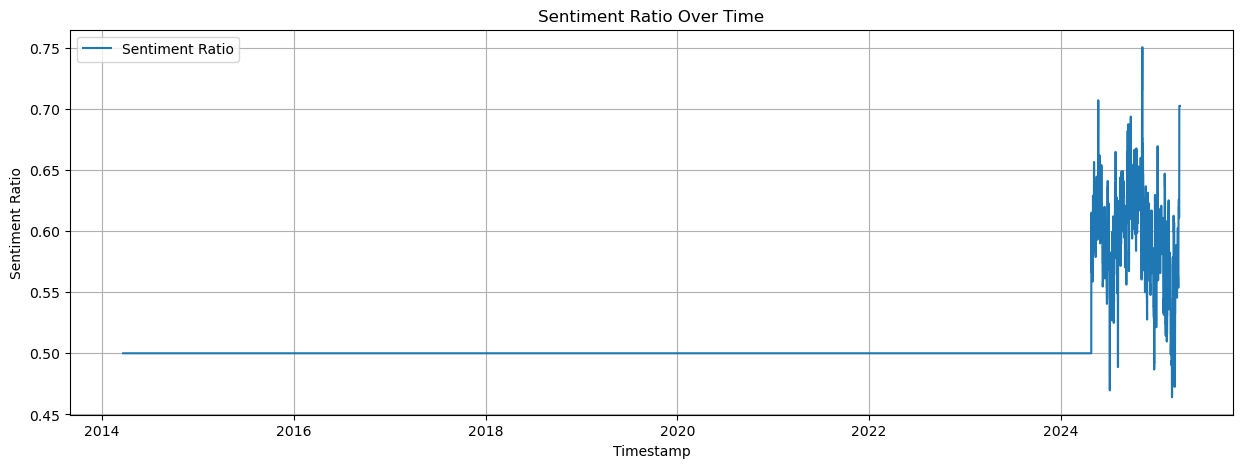

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
merged_df = pd.read_csv('final_dataset_with_sentiment_cleaned.csv')

# Parse timestamp
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], errors='coerce')

# 1. Check if timestamps are regular (1 hour apart everywhere)
print("\nChecking timestamp regularity...")
time_diffs = merged_df['timestamp'].diff().value_counts()

print(time_diffs)

# Should show only: 0 days 01:00:00

if len(time_diffs) == 1 and pd.Timedelta('1H') in time_diffs.index:
    print("✅ Timestamps are perfectly hourly.")
else:
    print("❌ Irregular timestamps detected!")

# 2. Check for any missing timestamps
print("\nChecking missing timestamps...")
expected_rows = ((merged_df['timestamp'].max() - merged_df['timestamp'].min()).total_seconds() // 3600) + 1
actual_rows = merged_df.shape[0]

print(f"Expected rows: {int(expected_rows)}, Actual rows: {actual_rows}")

if expected_rows == actual_rows:
    print("✅ No missing timestamps.")
else:
    print("❌ Missing timestamps exist!")

# 3. Check for missing values in important columns
print("\nChecking missing values...")
important_columns = ['open', 'high', 'low', 'close', 'volume', 'sentiment_positive_total', 'sentiment_negative_total', 'sentiment_ratio']

missing = merged_df[important_columns].isnull().sum()

print(missing)

if missing.sum() == 0:
    print("✅ No missing values in critical columns.")
else:
    print("❌ Some missing values detected!")

# 4. Check that sentiment is constant within each day
print("\nChecking sentiment stability within a day...")

merged_df['day'] = merged_df['timestamp'].dt.date
day_sentiment_changes = merged_df.groupby('day')['sentiment_ratio'].nunique()

if (day_sentiment_changes > 1).any():
    print("❌ Sentiment changes detected within a day!")
else:
    print("✅ Sentiment stable per day.")

# 5. Visual check: Plot sentiment
print("\nPlotting sentiment ratio over time...")
plt.figure(figsize=(15,5))
plt.plot(merged_df['timestamp'], merged_df['sentiment_ratio'], label='Sentiment Ratio')
plt.title('Sentiment Ratio Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Ratio')
plt.legend()
plt.grid()
plt.show()

In [25]:
# Look at raw positive sentiment fetched
print(positive_df.head(50))  # First 50 rows

    timestamp  sentiment_positive_total
0  2024-04-26                931.770244
1  2024-04-27                715.575768
2  2024-04-28                763.869594
3  2024-04-29                961.620767
4  2024-04-30               1191.512148
5  2024-05-01               1174.900750
6  2024-05-02               1037.063190
7  2024-05-03               1041.455798
8  2024-05-04                782.025357
9  2024-05-05                675.003207
10 2024-05-06                881.500085
11 2024-05-07                958.897036
12 2024-05-08                985.121416
13 2024-05-09                991.011078
14 2024-05-10                922.724745
15 2024-05-11                710.143865
16 2024-05-12                650.261509
17 2024-05-13                949.995364
18 2024-05-14                934.800856
19 2024-05-15               1138.881961
20 2024-05-16               1079.028366
21 2024-05-17                832.309331
22 2024-05-18                534.599065
23 2024-05-19                525.341926


In [26]:
# Look at raw negative sentiment fetched
print(negative_df.head(50))  # First 50 rows


    timestamp  sentiment_negative_total
0  2024-04-26                583.073177
1  2024-04-27                548.434498
2  2024-04-28                482.092265
3  2024-04-29                611.397842
4  2024-04-30                902.038934
5  2024-05-01                927.914532
6  2024-05-02                612.027442
7  2024-05-03                663.926799
8  2024-05-04                559.542237
9  2024-05-05                427.787401
10 2024-05-06                461.238082
11 2024-05-07                632.716362
12 2024-05-08                675.850433
13 2024-05-09                599.260063
14 2024-05-10                603.039002
15 2024-05-11                433.858328
16 2024-05-12                473.313744
17 2024-05-13                554.902194
18 2024-05-14                613.080777
19 2024-05-15                643.294934
20 2024-05-16                595.086941
21 2024-05-17                500.415351
22 2024-05-18                326.683231
23 2024-05-19                360.677459


In [30]:
import requests

API_KEY = 'qrp5ubksareynqw7_qpjfxo7bcfcmpqxg'
SANBASE_URL = 'https://api.santiment.net/graphql'

# Very short query to check earliest available data for Bitcoin
query = """
{
  getMetric(metric: "sentiment_positive_total") {
    timeseriesData(
      slug: "bitcoin",
      from: "2012-01-01T00:00:00Z",
      to: "2012-01-03T00:00:00Z",
      interval: "1d"
    ) {
      datetime
      value
    }
  }
}
"""

headers = {
    'Authorization': f'Apikey {API_KEY}',
    'Content-Type': 'application/json',
}

response = requests.post(SANBASE_URL, json={'query': query}, headers=headers)

if response.status_code == 200:
    result = response.json()
    if 'errors' in result:
        print("API returned errors:")
        print(result['errors'])
    else:
        timeseries = result['data']['getMetric']['timeseriesData']
        print("Timeseries fetched:")
        for entry in timeseries:
            print(entry)
else:
    print(f"HTTP Error {response.status_code}: {response.text}")


API returned errors:
[{'message': 'Both `from` and `to` parameters are outside the allowed interval you can query sentiment_positive_total with your current subscription SANAPI FREE. Upgrade to a higher tier in order to access more data.\n\nAllowed time restrictions:\n  - `from` - 2024-04-26 00:15:24.161894Z\n  - `to` - 2025-03-27 00:15:24.161894Z\n', 'path': ['getMetric', 'timeseriesData'], 'locations': [{'line': 4, 'column': 5}]}]


In [1]:
import os
import pandas as pd

# --- CONFIGURATION ---
folder_path = 'New Data'  

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

print(f"Found {len(csv_files)} CSV files.\n")

# --- Step 1: Load each CSV and print head ---
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    print(f"🟢 Loading file: {file}")
    
    try:
        # Try UTF-8 first
        df = pd.read_csv(file_path)
    except UnicodeDecodeError:
        print(f"⚠️ UTF-8 failed for {file}, trying ISO-8859-1 encoding...")
        try:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
        except Exception as e2:
            print(f"❌ Failed to load {file} even with ISO-8859-1: {e2}")
            continue
    except Exception as e:
        print(f"❌ Other error loading {file}: {e}")
        continue

    print(f"🔹 Columns in {file}: {list(df.columns)}")
    print(df.head(3))
    print("\n" + "-"*70 + "\n")


Found 13 CSV files.

🟢 Loading file: Bitcoin_data.csv
⚠️ UTF-8 failed for Bitcoin_data.csv, trying ISO-8859-1 encoding...
🔹 Columns in Bitcoin_data.csv: ['Unnamed: 0', 'Date', 'User', 'Tweet']
   Unnamed: 0                       Date            User  \
0           0  2023-01-26 22:02:34+00:00       SeanButta   
1           1  2023-01-26 17:37:38+00:00    yfinanceplus   
2           2  2023-01-26 16:50:14+00:00  ImrichKasperko   

                                               Tweet  
0  Stacks' network usage was â¬ï¸ in Q4, result...  
1  The crypto market is having a (majority) green...  
2  @KaddeXofficial @Bitcoin @ethereum @kadena_io ...  

----------------------------------------------------------------------

🟢 Loading file: Bitcoin_tweets.csv


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_96791/375419805.py:18: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🔹 Columns in Bitcoin_tweets.csv: ['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'is_retweet']
       user_name    user_location  \
0  DeSota Wilson      Atlanta, GA   
1       CryptoND              NaN   
2      Tdlmatias  London, England   

                                    user_description         user_created  \
0  Biz Consultant, real estate, fintech, startups...  2009-04-26 20:05:09   
1  😎 BITCOINLIVE is a Dutch platform aimed at inf...  2019-10-17 20:12:10   
2  IM Academy : The best #forex, #SelfEducation, ...  2014-11-10 10:50:37   

  user_followers user_friends user_favourites user_verified  \
0         8534.0         7605            4838         False   
1         6769.0         1532           25483         False   
2          128.0          332             924         False   

                  date                                             

/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_96791/375419805.py:18: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


🔹 Columns in bitcoin_reddit_all.csv: ['Unnamed: 0', 'datetime', 'date', 'author', 'subreddit', 'created_utc', 'score', 'controversiality', 'body']
  Unnamed: 0             datetime        date       author  subreddit  \
0          0  2014-06-26 16:49:41  2014-06-26  HonorConnor  AskReddit   
1          1  2014-05-17 23:30:36  2014-05-17     Talvoren  AskReddit   
2          2  2014-12-18 04:54:48  2014-12-18     ninjoe87   Outdoors   

    created_utc  score  controversiality  \
0  1.403801e+09  162.0               0.0   
1  1.400369e+09   75.0               0.0   
2  1.418878e+09   -4.0               0.0   

                                                body  
0  How do you feel about Bitcoin? I don't really ...  
1  [The guy who blew a huge portion of his and hi...  
2  Because you are a damn liar.\n\nFrom my other ...  

----------------------------------------------------------------------

🟢 Loading file: RealtimeTweets.csv
🔹 Columns in RealtimeTweets.csv: ['User', 'Created_at',

In [1]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import logging
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- CONFIGURATION ---
folder_path = 'New Data'  # <-- Folder where all your CSVs are
ohlcv_path = 'final_data.csv'  # <-- Your OHLCV file
output_path = 'final_dataset_sentiment_expanded.csv'
train_output_path = 'train_data.csv'
val_output_path = 'val_data.csv'

# Setup logging
logging.basicConfig(filename='errors.log', level=logging.ERROR)

# --- Step 1: Load OHLCV ---
print("Loading OHLCV data...")
ohlcv = pd.read_csv(ohlcv_path)
ohlcv['timestamp'] = pd.to_datetime(ohlcv['timestamp'], unit='s', errors='coerce')
ohlcv['timestamp'] = ohlcv['timestamp'].dt.floor('H')
ohlcv = ohlcv.sort_values('timestamp').drop_duplicates('timestamp')
print(f"OHLCV loaded: {ohlcv.shape}")

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# --- Helper functions ---
def safe_read_csv(file_path):
    try:
        return pd.read_csv(file_path)
    except UnicodeDecodeError:
        try:
            return pd.read_csv(file_path, encoding='ISO-8859-1')
        except Exception as e:
            logging.error(f"Encoding fail {file_path}: {e}")
            return None
    except Exception as e:
        logging.error(f"Loading fail {file_path}: {e}")
        return None

def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))
    return score['compound']

# --- Step 2: Load Sentiment Datasets ---
print("Loading sentiment datasets...")
files = os.listdir(folder_path)

tweets_list = []
reddit_list = []
fear_greed_df = None

for file in files:
    if not file.endswith('.csv'):
        continue
    file_path = os.path.join(folder_path, file)
    df = safe_read_csv(file_path)
    if df is None:
        continue

    print(f"Processing {file}...")

    # Tweets
    if 'Bitcoin_data' in file or 'Bitcoin_tweets' in file or 'BTC_Tweets' in file or 'RealtimeTweets' in file:
        if 'Tweet' in df.columns or 'text' in df.columns or 'Tweet_Text' in df.columns:
            text_col = 'Tweet' if 'Tweet' in df.columns else ('text' if 'text' in df.columns else 'Tweet_Text')
            date_col = 'Date' if 'Date' in df.columns else ('date' if 'date' in df.columns else 'Created_at')

            df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)

            if 'New_Sentiment_Score' in df.columns:
                df['tweet_sentiment'] = df['New_Sentiment_Score']
            elif 'sentiment' in df.columns:
                df['tweet_sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
            else:
                df['tweet_sentiment'] = df[text_col].apply(get_vader_sentiment)

            tweets_list.append(df[['timestamp', 'tweet_sentiment']])

    # Reddit
    elif 'reddit' in file or 'Bitcoin.csv' in file:
        if 'body' in df.columns or 'title' in df.columns:
            text_col = 'body' if 'body' in df.columns else 'title'
            date_col = 'timestamp' if 'timestamp' in df.columns else ('datetime' if 'datetime' in df.columns else 'created')

            df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)
            df['reddit_sentiment'] = df[text_col].apply(get_vader_sentiment)

            reddit_list.append(df[['timestamp', 'reddit_sentiment']])

    # Fear and Greed
    elif 'dataset' in file:
        if 'Date' in df.columns and 'Value' in df.columns:
            fg = df[['Date', 'Value']].copy()
            fg['timestamp'] = pd.to_datetime(fg['Date'], errors='coerce')
            fg['fear_greed'] = fg['Value']
            fear_greed_df = fg[['timestamp', 'fear_greed']]

print("Sentiment datasets loaded.")

# --- Step 3: Aggregate Sentiment Hourly ---
print("Aggregating tweet sentiment hourly...")
if tweets_list:
    tweets_all = pd.concat(tweets_list, ignore_index=True)
    tweets_all.drop_duplicates(subset=['timestamp', 'tweet_sentiment'], inplace=True)
    tweets_all['timestamp'] = tweets_all['timestamp'].dt.floor('H')
    tweets_hourly = tweets_all.groupby('timestamp').agg(
        avg_tweet_sentiment=('tweet_sentiment', 'mean'),
        tweet_volume=('tweet_sentiment', 'count'),
        tweet_sentiment_std=('tweet_sentiment', 'std')
    ).reset_index()
else:
    tweets_hourly = pd.DataFrame()

print("Aggregating reddit sentiment hourly...")
if reddit_list:
    reddit_all = pd.concat(reddit_list, ignore_index=True)
    reddit_all.drop_duplicates(subset=['timestamp', 'reddit_sentiment'], inplace=True)
    reddit_all['timestamp'] = reddit_all['timestamp'].dt.floor('H')
    reddit_hourly = reddit_all.groupby('timestamp').agg(
        avg_reddit_sentiment=('reddit_sentiment', 'mean'),
        reddit_volume=('reddit_sentiment', 'count'),
        reddit_sentiment_std=('reddit_sentiment', 'std')
    ).reset_index()
else:
    reddit_hourly = pd.DataFrame()

# --- Step 4: Expand Fear and Greed to Hourly ---
print("Expanding Fear and Greed index to hourly...")
if fear_greed_df is not None:
    fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp']).dt.floor('D')
    full_hours = pd.date_range(start=ohlcv['timestamp'].min(), end=ohlcv['timestamp'].max(), freq='H')
    fg_expanded = pd.DataFrame({'timestamp': full_hours})
    fg_expanded['date_only'] = fg_expanded['timestamp'].dt.floor('D')
    fear_greed_df['date_only'] = fear_greed_df['timestamp']
    fg_expanded = fg_expanded.merge(fear_greed_df[['date_only', 'fear_greed']], on='date_only', how='left')
    fg_expanded.drop(columns=['date_only'], inplace=True)
else:
    fg_expanded = pd.DataFrame()

# --- Step 5: Merge Everything Together ---
print("Merging sentiment features into OHLCV...")

merged = ohlcv.copy()

if not tweets_hourly.empty:
    merged = pd.merge(merged, tweets_hourly, on='timestamp', how='left')

if not reddit_hourly.empty:
    merged = pd.merge(merged, reddit_hourly, on='timestamp', how='left')

if not fg_expanded.empty:
    merged = pd.merge(merged, fg_expanded, on='timestamp', how='left')

merged = merged.sort_values('timestamp').reset_index(drop=True)

# --- Step 6: Handle Missing Values ---
print("Handling missing values...")
merged['avg_tweet_sentiment'].fillna(0, inplace=True)
merged['tweet_volume'].fillna(0, inplace=True)
merged['avg_reddit_sentiment'].fillna(0, inplace=True)
merged['reddit_volume'].fillna(0, inplace=True)
merged['fear_greed'].fillna(method='ffill', inplace=True)
merged['fear_greed'].fillna(merged['fear_greed'].mean(), inplace=True)

# Fill missing std deviations
merged['tweet_sentiment_std'].fillna(0, inplace=True)
merged['reddit_sentiment_std'].fillna(0, inplace=True)

# --- Step 7: Create Sentiment Momentum Features ---
print("Creating sentiment momentum features...")
merged['tweet_sentiment_momentum'] = merged['avg_tweet_sentiment'].diff().fillna(0)
merged['reddit_sentiment_momentum'] = merged['avg_reddit_sentiment'].diff().fillna(0)

# --- Step 8: Normalize Selected Features ---
print("Normalizing selected features...")
scaler = MinMaxScaler()

# Select features to normalize
to_scale = ['open', 'high', 'low', 'close', 'volume', 
            'avg_tweet_sentiment', 'avg_reddit_sentiment',
            'tweet_sentiment_std', 'reddit_sentiment_std',
            'tweet_sentiment_momentum', 'reddit_sentiment_momentum',
            'fear_greed']

merged[to_scale] = scaler.fit_transform(merged[to_scale])

# --- Step 9: Save Final Dataset ---
print("Saving full merged dataset...")
merged.to_csv(output_path, index=False)
print(f"Dataset saved successfully to {output_path}.")

# --- Step 10: Optional Time-based Train/Validation Split ---
print("Splitting into train and validation sets...")
train_cutoff = pd.Timestamp('2022-01-01')
train_df = merged[merged['timestamp'] < train_cutoff]
val_df = merged[merged['timestamp'] >= train_cutoff]

train_df.to_csv(train_output_path, index=False)
val_df.to_csv(val_output_path, index=False)

print(f"Train dataset saved to {train_output_path}")
print(f"Validation dataset saved to {val_output_path}")

print("Pipeline complete.")


Loading OHLCV data...
OHLCV loaded: (96543, 6)
Loading sentiment datasets...
Processing Bitcoin_data.csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


Processing Bitcoin_tweets.csv...
Processing dataset (1).csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:32: DtypeWarning: Columns (0,1,2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


Processing bitcoin_reddit_all.csv...
Processing RealtimeTweets.csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)


Processing mbsa.csv...
Processing RealtimeTweets1.csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)


Processing bitcoin-sentiment-tweets.csv...
Processing Bitcoin.csv...
Processing BTC_Tweets_Updated.csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)


Processing BTC_Tweets.csv...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df[date_col], errors='coerce', utc=True).dt.tz_convert(None)


Processing dataset.csv...
Sentiment datasets loaded.
Aggregating tweet sentiment hourly...
Aggregating reddit sentiment hourly...
Expanding Fear and Greed index to hourly...
Merging sentiment features into OHLCV...
Handling missing values...
Creating sentiment momentum features...
Normalizing selected features...
Saving full merged dataset...


/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp']).dt.floor('D')
/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fear_greed_df['date_only'] = fear_greed_df['timestamp']
/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_97191/63855642.py:165: FutureWarning: Series.fillna wit

Dataset saved successfully to final_dataset_sentiment_expanded.csv.
Splitting into train and validation sets...
Train dataset saved to train_data.csv
Validation dataset saved to val_data.csv
Pipeline complete.


In [2]:
df = pd.read_csv("final_dataset_sentiment_expanded.csv")

In [3]:
df.head()

,timestamp,open,high,low,close,volume,avg_tweet_sentiment,tweet_volume,tweet_sentiment_std,avg_reddit_sentiment,reddit_volume,reddit_sentiment_std,fear_greed,tweet_sentiment_momentum,reddit_sentiment_momentum
0,2014-03-22 00:00:00,0.008174,0.006408,0.008206,0.008166,0.0,0.495198,0.0,0.0,0.623746,65.0,0.520340,0.479183,0.496747,0.384790
1,2014-03-22 01:00:00,0.008174,0.006408,0.008206,0.008166,0.0,0.495198,0.0,0.0,0.679171,54.0,0.543962,0.479183,0.496747,0.427045
2,2014-03-22 02:00:00,0.008174,0.006408,0.008206,0.008166,0.0,0.495198,0.0,0.0,0.613513,57.0,0.535242,0.479183,0.496747,0.334733
3,2014-03-22 03:00:00,0.008174,0.006408,0.008206,0.008166,0.0,0.495198,0.0,0.0,0.584018,46.0,0.479463,0.479183,0.496747,0.362303
4,2014-03-22 04:00:00,0.008174,0.006408,0.008206,0.008166,0.0,0.692347,1.0,0.0,0.660090,47.0,0.491839,0.479183,0.615018,0.442788


In [8]:
df.tail()

,timestamp,open,high,low,close,volume,avg_tweet_sentiment,tweet_volume,tweet_sentiment_std,avg_reddit_sentiment,reddit_volume,reddit_sentiment_std,fear_greed,tweet_sentiment_momentum,reddit_sentiment_momentum
96538,2025-03-29 15:00:00,0.762583,0.598378,0.763769,0.760915,0.000009,0.495198,0.0,0.0,0.475589,0.0,0.0,0.644444,0.496747,0.38479
96539,2025-03-29 16:00:00,0.762474,0.598854,0.761960,0.759164,0.000007,0.495198,0.0,0.0,0.475589,0.0,0.0,0.644444,0.496747,0.38479
96540,2025-03-29 17:00:00,0.759858,0.597386,0.757840,0.759354,0.000071,0.495198,0.0,0.0,0.475589,0.0,0.0,0.644444,0.496747,0.38479
96541,2025-03-29 18:00:00,0.760303,0.597601,0.761668,0.761279,0.000062,0.495198,0.0,0.0,0.475589,0.0,0.0,0.644444,0.496747,0.38479
96542,2025-03-29 19:00:00,0.760654,0.596998,0.762843,0.760078,0.000006,0.495198,0.0,0.0,0.475589,0.0,0.0,0.644444,0.496747,0.38479


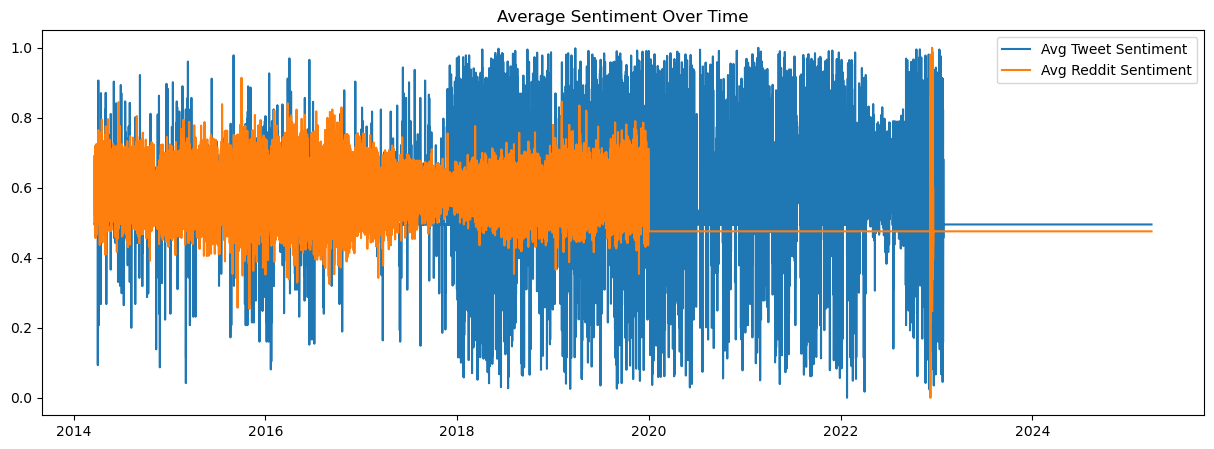

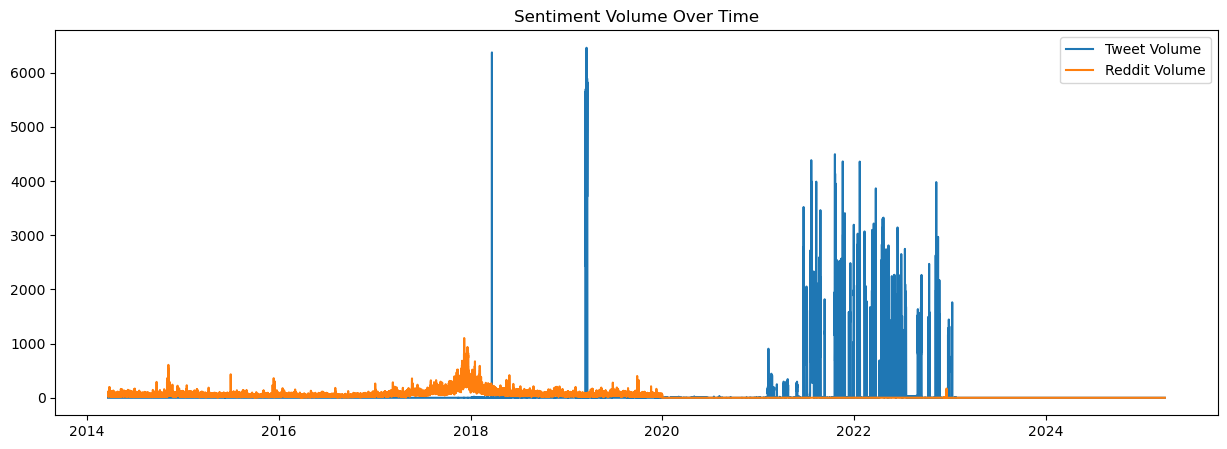

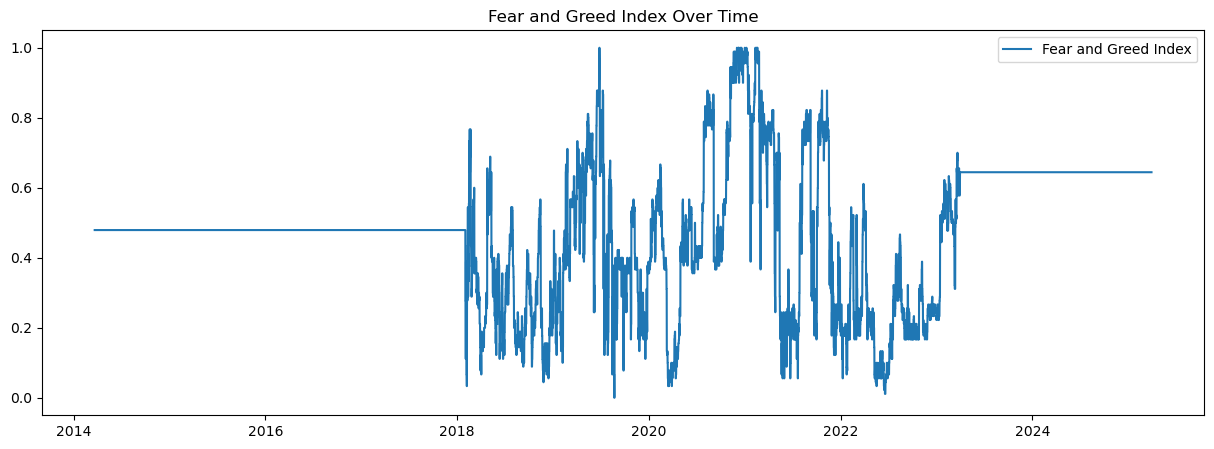

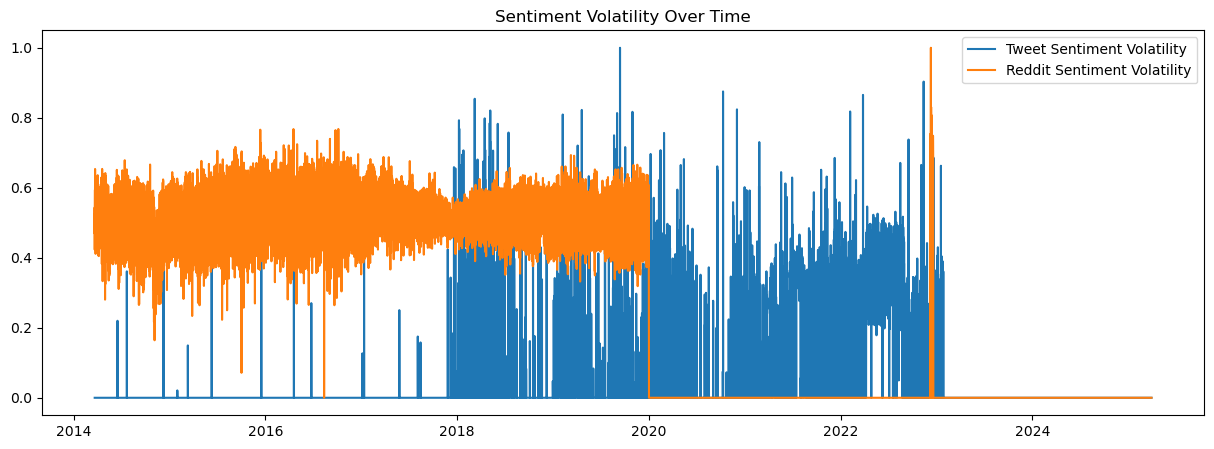

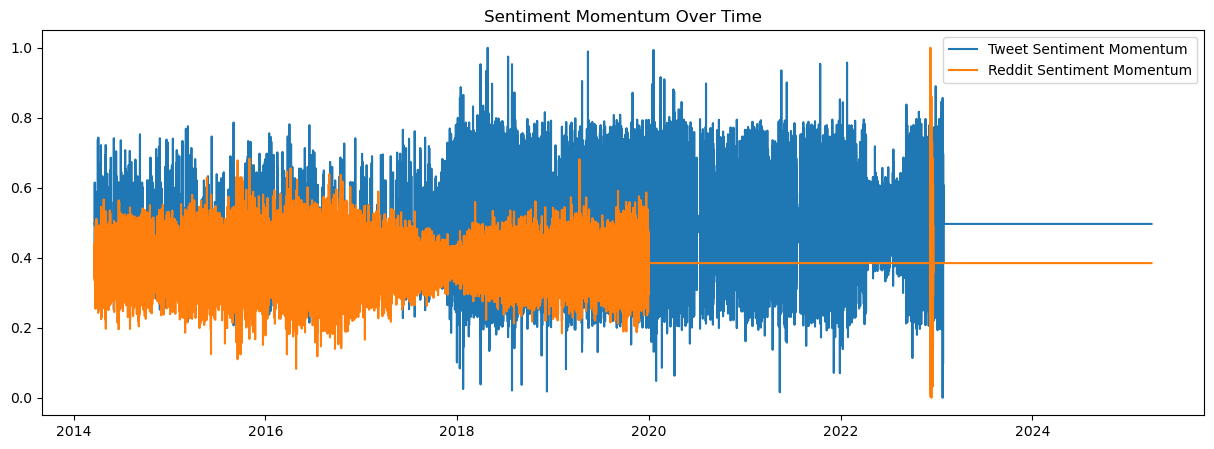

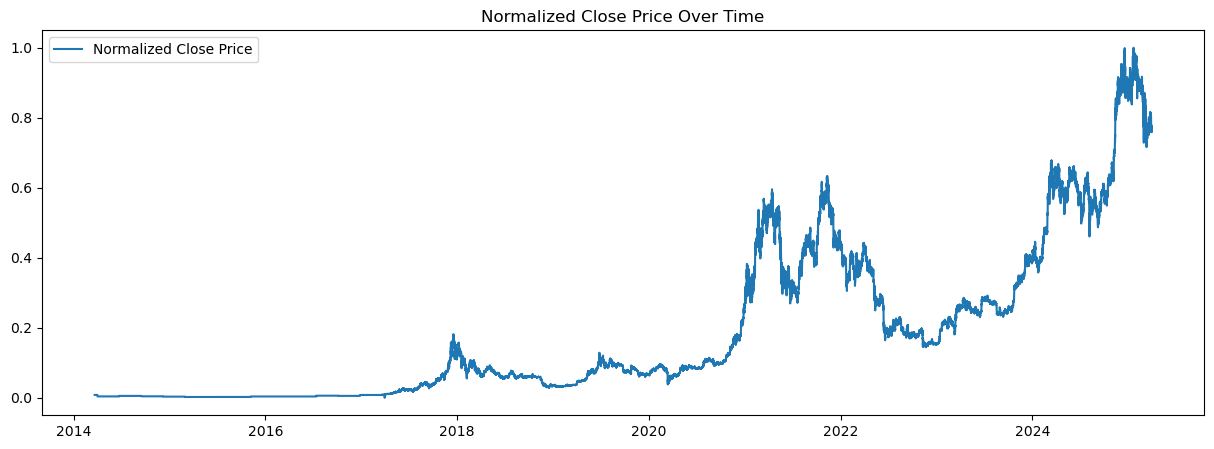

In [9]:
import matplotlib.pyplot as plt

# Load the merged dataset if not already loaded
merged = pd.read_csv('final_dataset_sentiment_expanded.csv')
merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# Set timestamp as index for easier plotting
merged.set_index('timestamp', inplace=True)

# --- Plot Average Sentiments ---
plt.figure(figsize=(15,5))
plt.plot(merged['avg_tweet_sentiment'], label='Avg Tweet Sentiment')
plt.plot(merged['avg_reddit_sentiment'], label='Avg Reddit Sentiment')
plt.title('Average Sentiment Over Time')
plt.legend()
plt.show()

# --- Plot Sentiment Volume (Tweet & Reddit Counts) ---
plt.figure(figsize=(15,5))
plt.plot(merged['tweet_volume'], label='Tweet Volume')
plt.plot(merged['reddit_volume'], label='Reddit Volume')
plt.title('Sentiment Volume Over Time')
plt.legend()
plt.show()

# --- Plot Fear and Greed Index ---
plt.figure(figsize=(15,5))
plt.plot(merged['fear_greed'], label='Fear and Greed Index')
plt.title('Fear and Greed Index Over Time')
plt.legend()
plt.show()

# --- Plot Sentiment Volatility (Standard Deviation) ---
plt.figure(figsize=(15,5))
plt.plot(merged['tweet_sentiment_std'], label='Tweet Sentiment Volatility')
plt.plot(merged['reddit_sentiment_std'], label='Reddit Sentiment Volatility')
plt.title('Sentiment Volatility Over Time')
plt.legend()
plt.show()

# --- Plot Sentiment Momentum (Change Over Time) ---
plt.figure(figsize=(15,5))
plt.plot(merged['tweet_sentiment_momentum'], label='Tweet Sentiment Momentum')
plt.plot(merged['reddit_sentiment_momentum'], label='Reddit Sentiment Momentum')
plt.title('Sentiment Momentum Over Time')
plt.legend()
plt.show()

# --- Optionally Plot Normalized Price (Close) ---
plt.figure(figsize=(15,5))
plt.plot(merged['close'], label='Normalized Close Price')
plt.title('Normalized Close Price Over Time')
plt.legend()
plt.show()